# **1. Introduction**

LendingClub is a US peer-to-peer lending company the world's largest peer-to-peer lending platform. According to Wikpedia

```
Lending Club enables borrowers to create unsecured personal loans between $1,000 and $40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.
```

In this project, we will only use data available to investors via the LendingClub listing. We will only consider loans that the LendingClub accepts under its credit underwriting policy.

# **2. Importing the Dataset**

The dataset can be found [here](https://www.kaggle.com/wordsforthewise/lending-club). It is a 1.8GB dataset with 1,646,801 loans and 150 variables for each loan. Download the file accepted_2007_to_2017Q3.csv.gz.zip locally onto your computer.

In [0]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Upload the file onto your colaboratory notebook.

In [2]:
from google.colab import files
uploaded = files.upload();

Saving accepted_2007_to_2017Q3.csv.gz to accepted_2007_to_2017Q3.csv.gz


In [3]:
loans = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip', low_memory=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# **3. Cleaning Up the Dataset**
We will predict the ```loan_status``` variable. We want to only consider loans that are either fully paid or charged off. We won't consider loans that are current, don't meet the policy, invalid, etc. 

In [4]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79.3% of loans are fully paid off and 20.6% of loans are charged off.

Next, drop all features with more than 30% of data missing.

In [0]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) #calculate percentage of missing data for each feature
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
loans.drop(labels=drop_list, axis=1, inplace=True)

Now, only use the features available to investors. 

In [0]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 
             'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 
             'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 
             'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 
             'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']
drop_list = [col for col in loans.columns if col not in keep_list]
loans.drop(labels=drop_list, axis=1, inplace=True)

# **4. Pre-Processing**
We will drop any features that are not useful for predicting the loan status and modify features to make it more useful for modeling.

In [7]:
loans.drop('id', axis=1, inplace=True) #every loan has unique id, categorical
loans.drop('grade', axis=1, inplace=True) #grade is implied by subgrade
loans.drop(labels='emp_title', axis=1, inplace=True) #too many different job titles

loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True) #convert emp_length to integers
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)
loans['emp_length'].value_counts(dropna=False).sort_index()

loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True) #replace values ANY and NONE with OTHER

loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1)) #take to log of incomes due to large range, drop annual_inc
loans.drop('annual_inc', axis=1, inplace=True)

loans.drop('title', axis=1, inplace=True) #too many titles
loans.drop(labels='zip_code', axis=1, inplace=True) #too many zip codes
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:])) #just retain the year for each loan

loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high'] #just keep the average of both FICO scores (low and high)
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1)) #log transform total credit revolving balance
loans.drop('revol_bal', axis=1, inplace=True)

loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8) #change loan_status to 0/1 variable
loans.drop('loan_status', axis=1, inplace=True) 

#create dummy variables for categorical variables
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state',
                                       'initial_list_status', 'application_type'], drop_first=True)

loans['issue_d'] = pd.to_datetime(loans['issue_d']) #convert issue dates to datetime objects)
loans['term'] = loans['term'].apply(lambda x: x[1:3]) #rmove 'months' so column becomes numerical
loans['term'].sample(5)


1107016    36
576177     36
885062     36
264408     60
188786     36
Name: term, dtype: object

Now we partition the test set rom the most recent 10% of loans.

In [8]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]
#del loans

loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

y_train = loans_train['charged_off']
y_test = loans_test['charged_off']
x_train = loans_train.drop('charged_off', axis=1)
x_test = loans_test.drop('charged_off', axis=1)

#del loans_train, loans_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
#loans_train.to_csv('loans_train.gz', compression='gzip')
#loans_test.to_csv('loans_test.gz', compression='gzip')

In [0]:
files.download('loans_train.csv')
files.download('loans_test.csv')

In [18]:
x_train.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
441496,2400.0,36,15.61,83.92,1.0,18.07,2004,12.0,0.0,4.3,28.0,0.0,0.0,4.544080,672.0,2.695482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
523507,6025.0,36,13.33,203.97,3.0,12.82,2007,8.0,0.0,36.8,32.0,0.0,0.0,4.730306,662.0,3.602928,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
889312,8000.0,36,17.77,288.30,3.0,18.50,2002,7.0,0.0,45.5,11.0,0.0,0.0,4.452568,692.0,3.755341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
927007,12000.0,36,15.31,417.81,2.0,24.47,1994,22.0,0.0,96.2,45.0,3.0,0.0,4.963793,672.0,4.307646,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40160,25000.0,36,7.69,779.84,7.0,5.81,2004,7.0,0.0,16.0,15.0,0.0,0.0,4.977728,767.0,3.590619,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# **5. Model Testing and Training**
### *5.1 Logistic Regression with SGD Training*

In [10]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

pipeline_sgdlogreg = Pipeline([
    ('imputer', Imputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=3, return_train_score=False)
grid_sgdlogreg.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] model__alpha=1e-05, model__penalty=l1 ...........................
[CV]  model__alpha=1e-05, model__penalty=l1, score=0.7010349148332748, total=  30.1s
[CV] model__alpha=1e-05, model__penalty=l1 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.1s remaining:    0.0s


[CV]  model__alpha=1e-05, model__penalty=l1, score=0.6898272896406376, total=  27.5s
[CV] model__alpha=1e-05, model__penalty=l1 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.5s remaining:    0.0s


[CV]  model__alpha=1e-05, model__penalty=l1, score=0.6758600455331221, total=  27.1s
[CV] model__alpha=1e-05, model__penalty=l1 ...........................
[CV]  model__alpha=1e-05, model__penalty=l1, score=0.6800974139856835, total=  30.9s
[CV] model__alpha=1e-05, model__penalty=l1 ...........................
[CV]  model__alpha=1e-05, model__penalty=l1, score=0.6796022027248863, total=  31.8s
[CV] model__alpha=1e-05, model__penalty=l2 ...........................
[CV]  model__alpha=1e-05, model__penalty=l2, score=0.6627710264892599, total=  23.6s
[CV] model__alpha=1e-05, model__penalty=l2 ...........................
[CV]  model__alpha=1e-05, model__penalty=l2, score=0.6892817148977037, total=  24.9s
[CV] model__alpha=1e-05, model__penalty=l2 ...........................
[CV]  model__alpha=1e-05, model__penalty=l2, score=0.6773933838807986, total=  24.4s
[CV] model__alpha=1e-05, model__penalty=l2 ...........................
[CV]  model__alpha=1e-05, model__penalty=l2, score=0.68600388763

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 11.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       e...ty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=0.001, verbose=0, warm_start=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__alpha': [1e-05, 0.01, 10], 'model__penalty': ['l1', 'l2']},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=3)

In [11]:
grid_sgdlogreg.best_score_

0.7138651282339733

In [12]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

### *5.2 Random Forest Classifier*

In [13]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rfc = Pipeline([
    ('imputer', Imputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=5, return_train_score=False)
grid_rfc.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] model__n_estimators=50 ..........................................
[CV] . model__n_estimators=50, score=0.6988771556208172, total= 2.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] model__n_estimators=50 ..........................................
[CV] . model__n_estimators=50, score=0.6959914822847133, total= 3.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.1min remaining:    0.0s


[CV] model__n_estimators=50 ..........................................
[CV] . model__n_estimators=50, score=0.6969829746589884, total= 2.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.6min remaining:    0.0s


[CV] model__n_estimators=50 ..........................................
[CV] . model__n_estimators=50, score=0.6946185959248549, total= 2.4min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 11.0min remaining:    0.0s


[CV] model__n_estimators=50 ..........................................
[CV] . model__n_estimators=50, score=0.6998522640011865, total= 2.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_im...stimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__n_estimators': [50]}, pre_dispatch=1,
       refit=True, return_train_score=False, scoring='roc_auc', verbose=5)

In [14]:
grid_rfc.best_score_

0.6972644945776202

### *5.3 K-Nearest Neighbors*

In [15]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn = Pipeline([
    ('imputer', Imputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

param_grid_knn = {
    'lda__n_components': [3, 9], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=2, return_train_score=False)

grid_knn.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] lda__n_components=3, model__n_neighbors=5 .......................
[CV] ........ lda__n_components=3, model__n_neighbors=5, total=  46.0s
[CV] lda__n_components=3, model__n_neighbors=5 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.0s remaining:    0.0s


[CV] ........ lda__n_components=3, model__n_neighbors=5, total=  42.1s
[CV] lda__n_components=3, model__n_neighbors=5 .......................
[CV] ........ lda__n_components=3, model__n_neighbors=5, total=  39.0s
[CV] lda__n_components=3, model__n_neighbors=5 .......................
[CV] ........ lda__n_components=3, model__n_neighbors=5, total=  33.6s
[CV] lda__n_components=3, model__n_neighbors=5 .......................
[CV] ........ lda__n_components=3, model__n_neighbors=5, total=  32.7s
[CV] lda__n_components=3, model__n_neighbors=25 ......................
[CV] ....... lda__n_components=3, model__n_neighbors=25, total=  33.3s
[CV] lda__n_components=3, model__n_neighbors=25 ......................
[CV] ....... lda__n_components=3, model__n_neighbors=25, total=  33.1s
[CV] lda__n_components=3, model__n_neighbors=25 ......................
[CV] ....... lda__n_components=3, model__n_neighbors=25, total=  33.6s
[CV] lda__n_components=3, model__n_neighbors=25 ......................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 19.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('lda', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
          ...ski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lda__n_components': [3, 9], 'model__n_neighbors': [5, 25, 125]},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=2)

In [16]:
grid_knn.best_score_

0.7098796124703738

In [17]:
grid_knn.best_params_

{'lda__n_components': 3, 'model__n_neighbors': 125}

### *5.4 Tune hyperparameters on the chosen model more finely*

In [18]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')
print(grid_knn.best_score_, '- k-nearest neighbors')

Cross-validated AUROC scores
0.7138651282339733 - Logistic regression
0.6972644945776202 - Random forest
0.7098796124703738 - k-nearest neighbors


In [19]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)
grid_sgdlogreg.fit(x_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed: 33.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=False, missing_values='NaN', strategy='mean', verbose=0)), ('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       e...ty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=0.001, verbose=0, warm_start=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__alpha': array([3.16228e-05, 1.00000e-04, 3.16228e-04, 1.00000e-03, 3.16228e-03,
       1.00000e-02, 3.16228e-02, 1.00000e-01, 3.16228e-01, 1.00000e+00,
       3.16228e+00]), 'model__penalty': ['l1', 'l2']},
       pre_dispatch=1, refit=True, return_train_score=False,
       scoring='roc_auc', verbose=1)

In [20]:
grid_sgdlogreg.best_score_

0.7138651282339733

In [21]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

### *5.5 Test Set Evaluation*

In [23]:
from sklearn.metrics import roc_auc_score

y_score = grid_sgdlogreg.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_score)

0.6893909107572427

# **6. Linear Regression**

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

y2_train = loans_train['int_rate']
y2_test = loans_test['int_rate']
x2_train = loans_train['fico_score']
x2_test = loans_test['fico_score']

In [75]:
x2_train.sample(5)

98520     702.0
807586    742.0
930208    697.0
287153    692.0
201600    692.0
Name: fico_score, dtype: float64

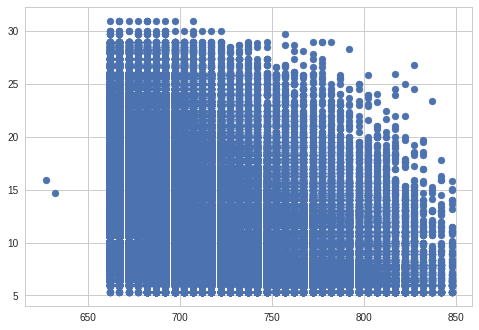

In [76]:
import matplotlib.pyplot as plt
from matplotlib import style
plt.scatter(x2_train, y2_train)
plt.show()

In [77]:
x2_train = x2_train.values.reshape(-1, 1)
y2_train = y2_train.values.reshape(-1, 1)
model = LinearRegression()
model.fit(x2_train, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
print(model.coef_)

[[-0.06387737]]


In [79]:
print(model.intercept_)

[57.92418676]


In [80]:
model.score(x2_train, y2_train)

0.1961753816975481

In [81]:
x2_test = x2_test.values.reshape(-1, 1)
y2_test = y2_test.values.reshape(-1, 1)
model.score(x2_test, y2_test)

0.05807515711056887